# Analysis Template - v5

`input`
- Raw Conversations Table
- Raw Interventions Table
- Protocol Name

`output`
- general_statistics.xlsx
- protocol_analysis.xlsx
- Protocol Analysis

v2: 
- This version aims to asses the impact of alerts of different nature (comparison, absolute value, etc.) for the same symptom

v3: 
- Overview of the general statistics for all protocols
- Double check alert count
- Improved the centralization of data at a single df
- Response time is computed with timeToConvert
- Export general statistics to an excel
- Export alert to intervention analysis to excel (BETA)

v3.1:
- Consider change in alert configuration, exporting a log of changes and using an updated symptoms_df

v3.2:
- Patients changing protocols is considered
- Registries of created and deleted interventions are considered

v3.3:
- Connect to firebase to explain the nature of the alert mapping the id

v4:
- Integrate conversation evolution statistics

v5:
- Refactoring code

# General Statistics Documentation

This document provides explanations for each variable used in the analysis.

- `protocolName`: The name of the protocol.
- `total_patients`: Total number of unique patients. Note that 'Total' is the sum of all unique patients per protocol, meaning some patients can have active profiles in more than one protocol and be counted more than once.
- `total_reached_patients`: Total number of patients reached. It represents how many unique patients have been reached at least once.
- `total_followups`: Total number of followups. This indicates how many followup attempts have been made. Note that one followup can be composed of multiple attempts.
- `total_duration`: Time in hours.
- `average_duration`: Time in minutes.
- `total_attempts`: Total number of attempted calls. It quantifies how many times in total there have been attempts to make a call.
- `total_answered`: Total number of answered calls. This number reflects how many calls have been answered.
- `total_completed`: Total number of completed calls. It shows how many calls have been completed until the end of the conversation.
- `total_alerts`: Total number of alerts.
- `total_conv_w_alert`: Total number of conversations with alerts.
- `total_conv_w_no_alert`: Total number of conversations with no alerts. This includes conversations that were completed but had no alerts.
- `total_interventions`: Total number of interventions.
- `prioritization_acc`: Prioritization accuracy. This is the percentage of conversations with an alert that have been actioned by the practitioner.


# Alert to Intervention Analysis Documentation

This document provides explanations for each variable used in the analysis.

- `protocolName`: The name of the protocol.
- `name`: Name of the symptom.
- `id`: Unique id associated to the alert. Different protocols can have different ids for the same alerts.
- `severity`: Severity classification of the alert associated to the symptom: HIGH, MEDIUM or LOW.
- `frequency score`: Average number of actions per alert.
- `prioritisation score`: Percentage of times some action is taken when the alert occurs (ratio over 1).
- `Number of Alerts`: Total number of alerts across all protocols.

In [275]:
import numpy as np
import pandas as pd
import ast
import itertools

from datetime import datetime, timezone

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

In [276]:
# Setting up a general plot style for consistency
# It doesn't fully work yet! :)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 8         

sns.set_palette('dark:#17024e_r') 

plt.rcParams['lines.linewidth'] = 2  
plt.rcParams['axes.grid'] = True    
plt.rcParams['axes.facecolor'] = 'white' 
plt.rcParams['figure.figsize'] = [6, 4]  

sns.set_style('whitegrid')

pd.set_option('plotting.backend', 'matplotlib')

# Pre processing

- Load raw data
- Remove created deleted interventions
- Make sure all df column formats are correct
- Adjust datetime format


In [368]:
df_raw_conversations = pd.read_csv('raw_conversations-Table 1.csv', sep=';', quoting=3, escapechar='\\')
df_raw_interventions = pd.read_csv('raw_interventions-Table 1.csv', sep=';', quoting=3, escapechar='\\')

In [369]:
def parse_time_to_convert(dataframe):
    # Check if 'timeToConvert' column exists
    if 'timeToConvert' in dataframe.columns:
        # Iterate over each item in 'timeToConvert' column
        for i, item in enumerate(dataframe['timeToConvert']):
            try:
                # Check if the item is a string and contains a comma
                if isinstance(item, str) and ',' in item:
                    # Replace comma with dot and convert to float
                    dataframe.at[i, 'timeToConvert'] = float(item.replace(',', '.'))
            except ValueError:
                # If conversion fails, it means the string is not a valid number
                pass
    return dataframe

def parse_string_lists_and_dicts(dataframe):
    for col in dataframe.columns:
        # Check if the column's data type is object, indicative of strings in pandas
        if dataframe[col].dtype == 'object':
            for i, item in enumerate(dataframe[col]):
                try:
                    # Attempt to parse each entry in the column
                    if isinstance(item, str):
                        dataframe.at[i, col] = ast.literal_eval(item)
                except (ValueError, SyntaxError):
                    # If ast.literal_eval fails, it means the string is not a valid list/dict
                    pass
    return dataframe

def convert_datetime_with_nanoseconds_to_datetime(datetime_with_nanoseconds):
    ts = datetime_with_nanoseconds/1000
    return (datetime.utcfromtimestamp(ts)).replace(tzinfo=timezone.utc)

def preprocess_dataframes(conversations_dataframe: pd.DataFrame(), interventions_dataframe: pd.DataFrame()):
    
    conversations_dataframe = parse_time_to_convert(conversations_dataframe)
    
    conversations_dataframe = parse_string_lists_and_dicts(conversations_dataframe)
    interventions_dataframe = parse_string_lists_and_dicts(interventions_dataframe)

    followup_map = dict(zip(conversations_dataframe['conversationId'], conversations_dataframe['followupId']))
    interventions_dataframe['followupId'] = interventions_dataframe['conversationId'].map(followup_map)
    count_df = interventions_dataframe.groupby(['name', 'followupId']).count()
    groups_to_remove = count_df[count_df['conversationId'] > 1].index

    interventions_dataframe = interventions_dataframe[ ~interventions_dataframe.set_index(['name', 'followupId']).index.isin(groups_to_remove)]

    interventions_dataframe['intervention datetime'] = interventions_dataframe['date'].apply(lambda x: convert_datetime_with_nanoseconds_to_datetime(x))
    conversations_dataframe['conversation datetime'] = conversations_dataframe['sentAt'].apply(lambda x: convert_datetime_with_nanoseconds_to_datetime(x))

    return conversations_dataframe, interventions_dataframe

In [370]:

df_conversations, df_interventions = preprocess_dataframes(df_raw_conversations, df_raw_interventions)

/var/folders/pz/qj_4jm0j2fs1026kt8lfr3200000gn/T/ipykernel_3345/1557375508.py:32: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return (datetime.utcfromtimestamp(ts)).replace(tzinfo=timezone.utc)
/var/folders/pz/qj_4jm0j2fs1026kt8lfr3200000gn/T/ipykernel_3345/1557375508.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interventions_dataframe['intervention datetime'] = interventions_dataframe['date'].apply(lambda x: convert_datetime_with_nanoseconds_to_datetime(x))
/var/folders/pz/qj_4jm0j2fs1026kt8lfr3200000gn/T/ipykernel_3345/1557375508.py:32: Deprecation

In [280]:
print("A total of", len(df_raw_interventions),"intervention registries.")
print("A total of", len(df_interventions),"interventions.")

A total of 63 intervention registries.
A total of 55 interventions.


In [281]:
# ALL PROTOCOLS
df_conversations['protocolName'].value_counts()

protocolName
Sintrom               147
Xarelto               131
Eliquis               113
Lixiana                80
Llamada bienvenida     57
Feedback               45
Pradaxa                22
Name: count, dtype: int64

In [282]:
# CLINICAL PROTOCOLS
df_clinical_conversations = df_conversations[df_conversations['alerts'].apply(lambda x: len(x) > 0)]
df_clinical_conversations['protocolName'].value_counts()

protocolName
Sintrom    147
Xarelto    131
Eliquis    113
Lixiana     80
Pradaxa     22
Name: count, dtype: int64

Interventions executed outside the scope of clinical protocols:

In [283]:
conversationIds_non_clinical = df_conversations[df_conversations['alerts'].apply(lambda x: len(x) == 0)]['conversationId']
df_interventions[df_interventions['conversationId'].isin(conversationIds_non_clinical)]

patientId           date                name  value status  \
0   F9lKYcWTcSFoOUQXmmVh  1677001541534  Llamada a paciente      1  added   
1   5Yf4YWcDYyjiSPCY3PYI  1677001899805  Llamada a paciente      1  added   
5   kqElmCMIKyLoQTSwsdBp  1677001616006  Llamada a paciente      1  added   
14  uz4Tumn0u5PIZ1is4B4m  1677747939105  Llamada a paciente      1  added   
20  U6PcRnKM1ru4XyC4NPYy  1678793751794  Llamada a paciente      1  added   

                       conversationId        interventionId interventionType  \
0   M4AyQmJ8GgB8X3YkEvXz1676554804621  jKDh34V3n4zS9uIcb2vs          boolean   
1   84r3wedMrzQ5Rdf1y1YQ1676490868912  hxyFrDolFTx1koRI41qA          boolean   
5   H0DEpnhnJQR59CKGo9Oe1676546847091  22J5zfk6BcJoyA6hW79r          boolean   
14  07uq9KMvzRb0TKjBTgoc1677681742117  fvhc08VWdDEC6Pp3omtE          boolean   
20  JD7jR6XFVTN0wvTKkJIg1678275943368  n4DlxqjwPQYBabXGUT0j          boolean   

              userName         day                   week    month quarter  \
0   Cristina Maldonado  2023-02-21  2023-02-20/2023-02-26  2023-02  2023Q1   
1   Cristina Maldonado  2023-02-21  2023-02-20/2023-02-26  2023-02  2023Q1   
5   Cristina Maldonado  2023-02-21  2023-02-20/2023-02-26  2023-02  2023Q1   
14  Cristina Maldonado  2023-03-02  2023-02-27/2023-03-05  2023-03  2023Q1   
20  Cristina Maldonado  2023-03-14  2023-03-13/2023-03-19  2023-03  2023Q1   

    calendarDay  calendarWeek  calendarMonth  calendarYear     gender  \
0            21             8              2          2023  Masculino   
1            21             8              2          2023  Masculino   
5            21             8              2          2023  Masculino   
14            2             9              3          2023  Masculino   
20           14            11              3          2023  Masculino   

                             followupId            intervention datetime  
0                  M4AyQmJ8GgB8X3YkEvXz 2023-02-21 17:45:41.534000+00:00  
1                  84r3wedMrzQ5Rdf1y1YQ 2023-02-21 17:51:39.805000+00:00  
5                  H0DEpnhnJQR59CKGo9Oe 2023-02-21 17:46:56.006000+00:00  
14  07uq9KMvzRb0TKjBTgoc202331130014003 2023-03-02 09:05:39.105000+00:00  
20  JD7jR6XFVTN0wvTKkJIg202338100011003 2023-03-14 11:35:51.794000+00:00

In [284]:
print("Total unique patients: ", df_conversations['patientId'].nunique())
print("Total unique patients in clinical protocols: ", df_conversations[df_conversations['alerts'].apply(lambda x: len(x) > 0)]['patientId'].nunique())

Total unique patients:  54
Total unique patients in clinical protocols:  53


In [285]:
min_date = df_conversations['conversation datetime'].min()
max_date = df_conversations['conversation datetime'].max()

print("DATA RANGE \n")
print("Min: ", min_date.strftime("%d-%m-%Y (%B)"))
print("Max: ", max_date.strftime("%d-%m-%Y (%B)"))

DATA RANGE 

Min:  09-02-2023 (February)
Max:  11-12-2023 (December)


## `general_statistics.xlsx`

In [286]:
def extract_ids(alerts_list):
    try:
        return [item['id'] for item in alerts_list if item.get('alert')]
    except:
        return ['error']
    
def get_alert_config(conversations_dataframe: pd.DataFrame(), protocol_name: str):

    log_changes = []
    master_df = pd.DataFrame(columns=['name', 'id', 'severity'])

    if len(conversations_dataframe.iloc[0]['alerts']) == 0:
        return master_df, log_changes

    creation = True

    for index, row in conversations_dataframe.iterrows():
        
        alerts_string = row['alerts']
        date = row['conversation datetime']

        df_symptoms = pd.DataFrame(alerts_string)
        df_symptoms = df_symptoms[['name', 'id', 'severity']]
        
        # Compare with the master DataFrame and update
        # We can compare on id and protocol name. Things that can happen: 
            # Practioners add new alert with the same alert name but different properties (same name, different id)
            # Practitioners change the name of the alert but the alert stays the same (different name, same id)
        # This approach considers all scenarios, but prioritizes changes in id, using the last modification for name
        
        new_symptoms_name = df_symptoms[~df_symptoms['name'].isin(master_df['name'])]
        new_symptoms_id = df_symptoms[~df_symptoms['id'].isin(master_df['id'])]

        if not new_symptoms_id.empty:
            
            if creation == False:
                log_changes.append({'date': date, 'new_symptoms': new_symptoms_id, 'protocol': protocol_name, 'type:': 'change in id'})
            
            master_df = pd.concat([master_df, new_symptoms_id])
        
        if not new_symptoms_name.empty:
    
            if creation == False:
                log_changes.append({'date': date, 'new_symptoms': new_symptoms_name, 'protocol': protocol_name, 'type': 'change in name'})
            
            master_df = pd.concat([master_df, new_symptoms_name])
        
        creation = False

    master_df = master_df.drop_duplicates(subset='id', keep='last')

    master_df.reset_index(drop=True, inplace=True)

    log_changes = pd.DataFrame(log_changes)

    return master_df, log_changes

def generate_alerts_matrix_dataframe(conversations_dataframe: pd.DataFrame(), protocol_name: str, with_low=True):

    protocol_conversations_dataframe = conversations_dataframe[conversations_dataframe['protocolName'] == protocol_name]
    protocol_conversations_dataframe = protocol_conversations_dataframe.dropna(axis=1, how='all')

    symptoms_dataframe, log_changes = get_alert_config(protocol_conversations_dataframe, protocol_name)

    if with_low == False:
        symptoms_dataframe = symptoms_dataframe[symptoms_dataframe['severity'] != 'LOW']
    
    protocol_conversations_dataframe['alert_ids'] = protocol_conversations_dataframe['alerts'].apply(extract_ids)

    rows = protocol_conversations_dataframe['conversationId'].unique()
    cols = symptoms_dataframe['id'].unique()

    alerts_dataframe = pd.DataFrame(0, index=rows, columns=cols)

    # Because now the indexes don't match, we need to map alert_ids to conversationId
    alert_map = dict(zip(protocol_conversations_dataframe['conversationId'], protocol_conversations_dataframe['alert_ids']))

    # Use the conversationId index of df_alerts to map the alertList values
    alerts_dataframe['alert_ids'] = alerts_dataframe.index.map(alert_map)

    for column in alerts_dataframe.columns:

        if column == 'alert_ids':
            continue

        # Update the column based on presence in alertList
        alerts_dataframe[column] = alerts_dataframe.apply(lambda row: sum(item.lower() == column.lower() for item in row['alert_ids']), axis=1)

    alerts_dataframe.drop('alert_ids', axis=1, inplace=True)

    alerts = alerts_dataframe.columns

    return alerts_dataframe, symptoms_dataframe, alerts, log_changes

def generate_interventions_matrix_dataframe(interventions_dataframe: pd.DataFrame()):
    
    unique_names = interventions_dataframe['name'].unique()
    unique_conversationIds = interventions_dataframe['conversationId'].unique()

    interventions_matrix_dataframe = pd.DataFrame(0, index=unique_conversationIds, columns=unique_names)
    
    for _, row in interventions_dataframe.iterrows():
        interventions_matrix_dataframe.at[row['conversationId'], row['name']] = 1

    interventions = interventions_matrix_dataframe.columns

    return interventions_matrix_dataframe, interventions

def get_protocol_statistics(conversations_dataframe: pd.DataFrame(), interventions_matrix_dataframe: pd.DataFrame(), interventions, protocol_name: str, with_low=True):
    
    alerts_matrix_dataframe, symptoms_dataframe, alerts, log_changes = generate_alerts_matrix_dataframe(conversations_dataframe, protocol_name, with_low=with_low)

    df = pd.merge(alerts_matrix_dataframe, interventions_matrix_dataframe, left_index=True, right_index=True, how='left')

    df = df.fillna(0)
    df[interventions] = df[interventions].astype(int)

    df['interventionNumber'] = df[interventions].sum(axis=1)
    df['alertNumber'] =alerts_matrix_dataframe[alerts].sum(axis=1)

    # Check alertNumber
    alertNumber_map = dict(zip(conversations_dataframe['conversationId'], conversations_dataframe['alertNumber']))
    df['check alertNumber'] = df.index.map(alertNumber_map)

    if df['alertNumber'].sum() != df['check alertNumber'].sum() and with_low==True:
        print("There is a discrepancy with alert numbers in: ", protocol_name)

    # Patient ID
    patientId_map = dict(zip(conversations_dataframe['conversationId'], conversations_dataframe['patientId']))
    df['patientId'] = df.index.map(patientId_map)

    # Answered
    answered_map = dict(zip(conversations_dataframe['conversationId'], conversations_dataframe['answered']))
    df['answered'] = df.index.map(answered_map)

    # Completed
    completed_map = dict(zip(conversations_dataframe['conversationId'], conversations_dataframe['completed']))
    df['completed'] = df.index.map(completed_map)

    # Repetition
    repetition_map = dict(zip(conversations_dataframe['conversationId'], conversations_dataframe['repetition']))
    df['repetition'] = df.index.map(repetition_map)

    # Duration
    duration_map = dict(zip(conversations_dataframe['conversationId'], conversations_dataframe['duration']))
    df['duration'] = df.index.map(duration_map)
    
    total_alert_conversations = len(df[df['alertNumber']>0])
    total_alert_intervention_conversations = len(df[(df['alertNumber']>0) & (df['interventionNumber']>0)])
    try:
        prioritisation_accuracy = total_alert_intervention_conversations / total_alert_conversations
    except ZeroDivisionError:
        prioritisation_accuracy = float('nan')

    # General statistics:
    statistics = {
        'protocolName': protocol_name,
        'total_patients': df['patientId'].nunique(),
        'total_reached_patients': df[df['answered'] == True]['patientId'].nunique(),
        'total_followups': len(df),
        'total_duration': df['duration'].sum()/360,
        'average_duration': df['duration'].mean()/60,
        'total_attempts': df['repetition'].sum() + len(df),
        'total_answered': len(df[df['answered'] == True]),
        'total_completed': len(df[df['completed'] == True]),
        'total_alerts': df['alertNumber'].sum().astype(int),
        'total_conv_w_alert': len(df[df['alertNumber'] > 0]),
        'total_conv_w_no_alert': len(df[(df['completed'] == True) & (df['alertNumber'] == 0)]),
        'total_interventions': df['interventionNumber'].sum(),
        'total_conv_w_intervention': len(df[df['interventionNumber'] > 0]),
        'prioritization_acc': prioritisation_accuracy
    }
    return statistics, df, alerts, interventions, symptoms_dataframe, log_changes

In [287]:
def general_statistics(conversations_dataframe, interventions_dataframe, only_clinical=True, with_low=True):

    all_statistics = []

    df_interventions_matrix, interventions = generate_interventions_matrix_dataframe(interventions_dataframe)

    protocols = conversations_dataframe['protocolName'].unique()

    if only_clinical == True:
        clinical_protocols = conversations_dataframe[conversations_dataframe['alerts'].apply(lambda x: len(x) > 0)]['protocolName'].unique()
        protocols = clinical_protocols

    for protocol_name in protocols:
        stats, _, _, _, _, _ = get_protocol_statistics(conversations_dataframe, df_interventions_matrix, interventions, protocol_name, with_low=with_low)
        all_statistics.append(stats)

    all_statistics = pd.DataFrame(all_statistics)

    total_stats = {'protocolName': 'Total'}

    # Iterate over each column except for 'protocolName'
    for column in all_statistics.columns:
        if column == 'protocolName':
            continue
        elif column == 'total_patients':
            if only_clinical == True:
                total_stats[column] = conversations_dataframe[conversations_dataframe['alerts'].apply(lambda x: len(x) > 0)]['patientId'].nunique()
            else:
                total_stats[column] = conversations_dataframe['patientId'].nunique()
        elif column == 'total_reached_patients':
            if only_clinical == True: 
                total_stats[column] = conversations_dataframe[conversations_dataframe['answered'] == True][conversations_dataframe[conversations_dataframe['answered'] == True]['alerts'].apply(lambda x: len(x) > 0)]['patientId'].nunique()
            else:
                total_stats[column] = conversations_dataframe[conversations_dataframe['answered'] == True]['patientId'].nunique()
        elif column == 'average_duration': # Weigthed average duration
            total_stats[column] = (all_statistics[column]*all_statistics['total_answered']).sum()/(all_statistics['total_answered'].sum())
        elif column == 'prioritization_acc': # Weighed priorization accuracy
            total_stats[column] = (all_statistics[column]*all_statistics['total_answered']).sum()/(all_statistics['total_answered'].sum())
        else:
            total_stats[column] = all_statistics[column].sum()

    total_stats_df = pd.DataFrame([total_stats])
    all_statistics = pd.concat([all_statistics, total_stats_df], ignore_index=True)

    return all_statistics.round(2)

In [288]:
all_statistics = general_statistics(df_conversations, df_interventions, only_clinical=True, with_low=False)
all_statistics

protocolName  total_patients  total_reached_patients  total_followups  \
0      Sintrom              19                      19              147   
1      Lixiana              10                      10               80   
2      Xarelto              15                      15              131   
3      Eliquis              13                      13              113   
4      Pradaxa               3                       3               22   
5        Total              53                      53              493   

   total_duration  average_duration  total_attempts  total_answered  \
0           76.41              3.12             216             133   
1           44.49              3.34             113              79   
2           61.28              2.81             240             106   
3           60.98              3.24             168             109   
4           13.49              3.68              39              18   
5          256.64              3.13             776             445   

   total_completed  total_alerts  total_conv_w_alert  total_conv_w_no_alert  \
0              128            43                  38                     90   
1               78            25                  18                     60   
2              100            49                  34                     67   
3              105            31                  23                     83   
4               18            24                  13                      5   
5              429           172                 126                    305   

   total_interventions  total_conv_w_intervention  prioritization_acc  
0                   33                         16                0.26  
1                    4                          3                0.11  
2                    4                          4                0.06  
3                    2                          2                0.09  
4                    7                          4                0.23  
5                   50                         29                0.14

The sum of patients can be different than the total sum of unique patients per clinical protocol. This is because some patients may have changed protocols during the treatment, and their IDs appear in different clinical protocols.

In [289]:
with pd.ExcelWriter('general_statistics.xlsx') as writer:
    all_statistics.to_excel(writer, sheet_name='STATISTICS', index=False)

In [290]:
# What patients have conversations in different clinical protocols?

changed_users_df = df_clinical_conversations[['patientId', 'conversationId', 'protocolName']].groupby(['patientId']).nunique()
changed_users_df = changed_users_df[changed_users_df['protocolName'] > 1]

users_overview_df = df_clinical_conversations[['patientId', 'conversationId', 'protocolName']].groupby(['patientId', 'protocolName']).nunique()
users_overview_df = users_overview_df.loc[changed_users_df.index][['conversationId']]

users_overview_df.rename(columns={'conversationId': 'Total number of conversations'}, inplace=True)

users_overview_df

Total number of conversations
patientId            protocolName                               
9KzkMrGV9hjLrfrHe6kh Sintrom                                   8
                     Xarelto                                   4
FMBcrdrx01lcSgeffbo9 Sintrom                                   4
                     Xarelto                                   7
HkeADPnFK60TH75vBs5L Lixiana                                   8
                     Pradaxa                                   3
R8taNezuTgRA8KzhDrBB Sintrom                                   2
                     Xarelto                                   9
itUD298SRcyDFYA9gJ6P Lixiana                                   7
                     Sintrom                                   3
kqElmCMIKyLoQTSwsdBp Sintrom                                   4
                     Xarelto                                   7
sWbN69IYr4dK5qTIWy1H Sintrom                                   8
                     Xarelto                                   3

## `general_conversation_evolution.xlsx`

In [291]:
def general_conversation_evolution(conversations_dataframe: pd.DataFrame(), interventions_dataframe: pd.DataFrame(), protocols: list, with_low=True):

    df = pd.DataFrame()

    df_interventions_matrix, interventions = generate_interventions_matrix_dataframe(interventions_dataframe)

    for protocol_name in protocols:
        _, df_current, alerts, interventions, _, _ = get_protocol_statistics(conversations_dataframe, df_interventions_matrix, interventions, protocol_name, with_low=with_low)
        df_current.drop(alerts, axis=1, inplace=True)
        df_current.drop(interventions, axis=1, inplace=True)
        df_current['protocolName'] = protocol_name
        df = pd.concat([df, df_current])

    # Date map
    date_map = dict(zip(conversations_dataframe['conversationId'], conversations_dataframe['conversation datetime']))
    df['conversation datetime'] = df.index.map(date_map)

    df = df.sort_values(by='conversation datetime')

    df['conversation number'] = df.groupby('patientId').cumcount() + 1

    return df

In [292]:
clinical_protocols = df_clinical_conversations['protocolName'].unique()

df_general_conversation_evolution = general_conversation_evolution(df_conversations, df_interventions, clinical_protocols, with_low=False)

In [293]:
# VIEW PATIENTS THAT ARE ALWAYS STABLE: Only generate low or no alerts

df_stable_patients = df_general_conversation_evolution[['patientId','alertNumber','interventionNumber', 'answered']].groupby('patientId').sum()
df_stable_patients[df_stable_patients ['alertNumber'] == 0]

alertNumber  interventionNumber  answered
patientId                                                      
2bW6gHSIDQ3U9lSwEKoV            0                   1         8
59nB14PubwyIx5VlB2rS            0                   0         9
Af8Fq5MMHrZynQIPxmAh            0                   0         1
F9lKYcWTcSFoOUQXmmVh            0                   0        10
JIHabSwFYrmOLeyXiz14            0                   0        11
Rjy6bFGngcde03Xro3yT            0                   0         2
TyJeF6xeMfAFqgyemMRX            0                   0         7
U6PcRnKM1ru4XyC4NPYy            0                   0         3
adjHPwJhYaALaWxt2Nvg            0                   0         1
b0sfhxIKAbpF9dMp8MoX            0                   0        12
r522BDg8c3mdpm9RGqwU            0                   0         1
sJrrNzEbVKZqcII5jZBT            0                   0        10
uz4Tumn0u5PIZ1is4B4m            0                   0         8
xFRLoQ0M5t9ipJct4YmV            0                   0        10

In [294]:
df_evolution = df_general_conversation_evolution[['conversation number','alertNumber','interventionNumber', 'answered']].groupby('conversation number').sum()
df_evolution

alertNumber  interventionNumber  answered
conversation number                                           
1                             11                   8        50
2                             19                  12        47
3                             29                  16        46
4                             29                   2        46
5                             14                   2        44
6                             18                   4        45
7                              6                   3        38
8                              9                   3        39
9                             18                   0        36
10                            14                   0        35
11                             5                   0        17
12                             0                   0         2

In [295]:
with pd.ExcelWriter('general_conversation_evolution.xlsx') as writer:
    df_evolution.to_excel(writer, sheet_name='General evolution', index=False)

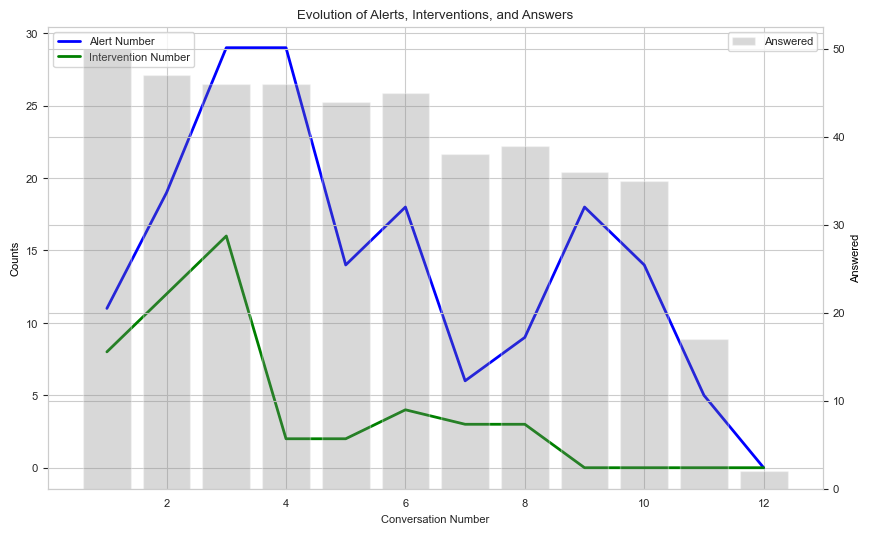

In [296]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Line plot for alertNumber and interventionNumber on the left y-axis
ax1.plot(df_evolution['alertNumber'], color='blue', label='Alert Number')
ax1.plot(df_evolution['interventionNumber'], color='green', label='Intervention Number')
ax1.set_xlabel('Conversation Number')
ax1.set_ylabel('Counts', color='black')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

# Creating a second y-axis for answered
ax2 = ax1.twinx()
ax2.bar(df_evolution.index, df_evolution['answered'], color='gray', alpha=0.3, label='Answered')
ax2.set_ylabel('Answered', color='black')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

# Show plot
plt.title('Evolution of Alerts, Interventions, and Answers')
plt.show()

In [297]:
df_evolution['r alertNumber'] = df_evolution['alertNumber']/df_evolution['answered']
df_evolution['r interventionNumber'] = df_evolution['interventionNumber']/df_evolution['answered']

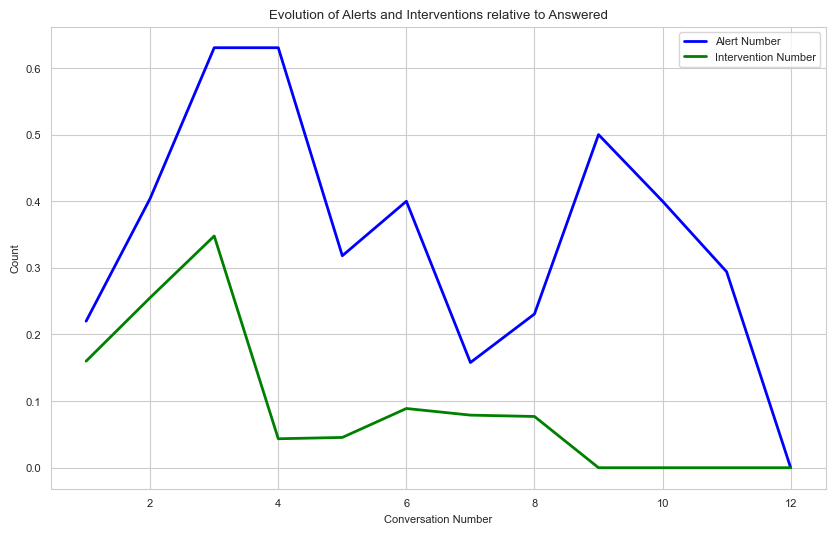

In [298]:
fig, ax = plt.subplots(figsize=(10, 6))

# Line plot for alertNumber
ax.plot(df_evolution['r alertNumber'], color='blue', label='Alert Number')

# Line plot for interventionNumber on the same y-axis
ax.plot(df_evolution['r interventionNumber'], color='green', label='Intervention Number')

# Setting labels and titles
ax.set_xlabel('Conversation Number')
ax.set_ylabel('Count')
ax.set_title('Evolution of Alerts and Interventions relative to Answered')

# Adding legend
ax.legend()

# Show plot
plt.show()

## `time_view.xlsx`

In [299]:
def generate_time_view(conversations_dataframe: pd.DataFrame(), interventions_dataframe: pd.DataFrame(), view='monthly', only_clinical=True):

    conversations_dataframe['daily'] = conversations_dataframe['conversation datetime'].dt.dayofyear
    conversations_dataframe['weekly'] = conversations_dataframe['conversation datetime'].dt.isocalendar().week
    conversations_dataframe['monthly'] = conversations_dataframe['conversation datetime'].dt.month

    df_interventions_matrix, interventions = generate_interventions_matrix_dataframe(interventions_dataframe)

    df_interventions_matrix['interventionNumber'] = df_interventions_matrix.sum(axis=1)

    df_view_expanded = pd.merge(conversations_dataframe, df_interventions_matrix, how='left', left_on='conversationId', right_index=True)

    protocols = conversations_dataframe['protocolName'].unique()

    if only_clinical == True:
        clinical_protocols = conversations_dataframe[conversations_dataframe['alerts'].apply(lambda x: len(x) > 0)]['protocolName'].unique()
        protocols = clinical_protocols
    
    df_view_expanded = df_view_expanded[df_view_expanded['protocolName'].isin(protocols)]

    df_view = df_view_expanded.groupby([view, 'protocolName']).apply(lambda x: pd.Series({
        'unique patients': x['patientId'].nunique(),
        'total attempts': x['conversationId'].nunique(),
        'total answered': x[x['answered'] == True]['answered'].count(),
        'total completed': x[x['completed'] == True]['completed'].count(),
        'total alerts': x['alertNumber'].sum(),
        'total conversations with alerts': x[x['alertNumber']>0]['conversationId'].count(),
        'total interventions': x['interventionNumber'].sum(),
        'total conversations with interventions': x[x['interventionNumber']>0]['conversationId'].count()
    }))

    return df_view   

In [300]:
view = 'weekly'

df_view = generate_time_view(df_conversations, df_interventions, view=view, only_clinical=True)

In [301]:
pivot_df = df_view.reset_index().pivot(index=view, columns='protocolName', values='unique patients')

# Calculate the percentage of answered calls per month
total_answered = df_view.groupby(view)['total answered'].sum()
total_completed = df_view.groupby(view)['total completed'].sum()
total_attempts = df_view.groupby(view)['total attempts'].sum()
percent_answered = (total_answered / total_attempts).reset_index()[0] * 100
percent_completed = (total_completed / total_attempts).reset_index()[0] * 100

# Plotting the stacked bar plot
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), legend=True, colormap='viridis')

# Overlay the line plots for percent answered and percent completed
percent_answered.plot(kind='line', color='red', marker='o', secondary_y=True, ax=ax)
percent_completed.plot(kind='line', color='green', marker='x', secondary_y=True, ax=ax)

# Setting up the primary y-axis (left)
ax.set_ylabel('Number of Unique Patients')
ax.set_xlabel(view)
ax.set_title('Unique Patients and Percentage of Calls')

# Setting up the secondary y-axis (right)
ax.right_ax.set_ylabel('Percentage of Calls')
ax.right_ax.set_ylim(0, 100)  # Set the y-axis range from 0 to 100
ax.right_ax.legend(['% Answered Calls', '% Completed Calls'], loc='upper right')

plt.show()

In [302]:
total_conversations_with_alerts = df_view.groupby(view)['total conversations with alerts'].sum()
total_conversations_with_interventions = df_view.groupby(view)['total conversations with interventions'].sum()
total_answered = df_view.groupby(view)['total answered'].sum()

# Ensure the indices match
total_conversations_with_alerts = total_conversations_with_alerts.reindex(pivot_df.index)
total_conversations_with_interventions = total_conversations_with_interventions.reindex(pivot_df.index)

# Compute percentages
percent_with_alerts = (total_conversations_with_alerts / total_answered) * 100
percent_with_interventions = (total_conversations_with_interventions / total_answered) * 100

# Plotting the line plots for percent with alerts and percent with interventions
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(percent_with_alerts.index, percent_with_alerts.values, color='blue', marker='o', label='% Conversations with Alerts')
ax1.plot(percent_with_interventions.index, percent_with_interventions.values, color='orange', marker='x', label='% Conversations with Interventions')

# Setting up the primary y-axis (left)
ax1.set_ylabel('Percentage of Conversations')
ax1.set_xlabel(view)
ax1.set_title('Percentage of Conversations with Alerts and Interventions')
ax1.set_ylim(0, 100)  # Set the y-axis range from 0 to 100
ax1.legend(loc='upper left')

plt.show()

## `protocols_analysis.xlsx`

In [303]:
def weighted_mean(values, weights):
    return (values * weights).sum() / weights.sum() if weights.sum() > 0 else 0

def get_protocol_alert_analysis(conversations_dataframe: pd.DataFrame(), interventions_dataframe: pd.DataFrame(), protocol_name, with_low=True):

    df_interventions_matrix, interventions = generate_interventions_matrix_dataframe(interventions_dataframe)
    
    _, df_alerts_matrix, alerts, interventions, symptoms_dataframe, log_changes = get_protocol_statistics(conversations_dataframe, df_interventions_matrix, interventions, protocol_name, with_low=with_low)
    
    frequencies_df = pd.DataFrame()

    for symptom in alerts:  
        frequencies = []
        for intervention in interventions:
            frequency = df_alerts_matrix[df_alerts_matrix[symptom] > 0][intervention].mean()
            frequencies.append(frequency)
        frequencies_df[symptom] = frequencies

    frequencies_df = frequencies_df.transpose()
    frequencies_df.columns = interventions
    frequencies_df['frequency score'] = frequencies_df.sum(axis=1)
    df_symptoms_analysis = pd.merge(symptoms_dataframe, frequencies_df[['frequency score']], how='outer', left_on='id', right_index=True)
    prioritisation_scores = {}

    for alert in alerts:
        total_conv = len(df_alerts_matrix[df_alerts_matrix[alert] > 0])
        total_act = len(df_alerts_matrix[(df_alerts_matrix[alert] > 0) & (df_alerts_matrix['interventionNumber'] > 0)])
        prioritisation_scores[alert] = total_act / total_conv if total_conv != 0 else float('nan')

    df_symptoms_analysis['prioritisation score'] = df_symptoms_analysis['id'].map(prioritisation_scores)
    df_symptoms_analysis = pd.merge(df_symptoms_analysis, pd.DataFrame(df_alerts_matrix[alerts].sum(), columns=['Number of Alerts']), how='outer', left_on='id', right_index=True)
    df_symptoms_analysis = df_symptoms_analysis.sort_values(by='frequency score', ascending=False)

    return df_symptoms_analysis, log_changes

# Initialize an empty DataFrame for all protocols
protocols_df = pd.DataFrame()
all_protocols_df = pd.DataFrame()
all_changes_log = pd.DataFrame(columns=['date', 'new_symptoms', 'protocol'])

with pd.ExcelWriter('protocols_analysis.xlsx') as writer:
    for protocol in clinical_protocols:

        df_symptoms_analysis, log_changes = get_protocol_alert_analysis(df_conversations, df_interventions, protocol, with_low=True)
        
        # Write the sorted DataFrame to a new sheet in the Excel file
        df_symptoms_analysis.to_excel(writer, sheet_name=protocol, index=False)

        df_symptoms_analysis['protocol_name'] = protocol  # Add protocol name as a new column

        protocols_df = pd.concat([protocols_df, df_symptoms_analysis], ignore_index=True)
        all_changes_log = pd.concat([all_changes_log, log_changes], ignore_index=True)
  
    all_protocols_df = protocols_df.groupby(['name', 'severity']).apply(lambda x: pd.Series({
        'id': list(x['id']),
        'frequency score': weighted_mean(x['frequency score'], x['Number of Alerts']),
        'prioritisation score': weighted_mean(x['prioritisation score'], x['Number of Alerts']),
        'Number of Alerts': x['Number of Alerts'].sum(),
        'protocol_name': list(x['protocol_name'])
    })).reset_index()

    all_protocols_df = all_protocols_df.sort_values(by='Number of Alerts', ascending=False)

    all_protocols_df.to_excel(writer, sheet_name='ALL_PROTOCOLS', index=False)
    
    # Ensure there are no entirely empty columns
    all_changes_log = all_changes_log.dropna(axis=1, how='all')

    if 'date' in all_changes_log.columns:
        # Check if it's a datetime64 type
        if pd.api.types.is_datetime64_any_dtype(all_changes_log['date']):
            all_changes_log['date'] = all_changes_log['date'].dt.strftime('%d-%m-%Y')
    else:
        print("No changes registered")

    # Save the DataFrame to Excel
    all_changes_log.to_excel(writer, sheet_name='changes log', index=False)

# The Excel file 'protocols_analysis.xlsx' is now saved with each protocol as a separate sheetwith pd.ExcelWriter('protocols_analysis.xlsx') as writer:

/var/folders/pz/qj_4jm0j2fs1026kt8lfr3200000gn/T/ipykernel_3345/4142809343.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_changes_log = pd.concat([all_changes_log, log_changes], ignore_index=True)


In [304]:
all_protocols_df = all_protocols_df.groupby(['name', 'severity']).apply(lambda x: pd.Series({
        'id': (x['id']),
        'frequency score': weighted_mean(x['frequency score'], x['Number of Alerts']),
        'prioritisation score': weighted_mean(x['prioritisation score'], x['Number of Alerts']),
        'Number of Alerts': x['Number of Alerts'].sum(),
        'protocol_name': (x['protocol_name'])
    }))

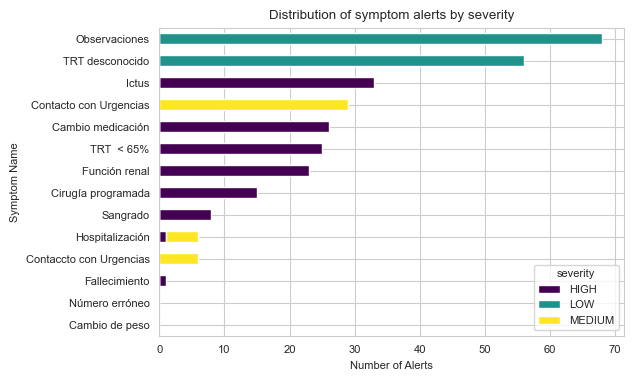

In [305]:
# Unstack the 'severity' level for plotting
unstacked_df = all_protocols_df['Number of Alerts'].unstack(level='severity')

# Sort the DataFrame based on the total number of alerts for each symptom
sorted_df = unstacked_df.assign(Total=unstacked_df.sum(axis=1)).sort_values(by='Total', ascending=True).drop('Total', axis=1)

# Plotting with pandas and matplotlib, but with Seaborn styling
sorted_df.plot(kind='barh', stacked=True, colormap='viridis')
plt.title('Distribution of symptom alerts by severity')
plt.xlabel('Number of Alerts')
plt.ylabel('Symptom Name')
plt.show()

In [306]:
all_protocols_df.sort_values(by='Number of Alerts', ascending=False)['Number of Alerts']

name                     severity
Observaciones            LOW         68
TRT desconocido          LOW         56
Ictus                    HIGH        33
Contacto con Urgencias   MEDIUM      29
Cambio medicación        HIGH        26
TRT  < 65%               HIGH        25
Función renal            HIGH        23
Cirugía programada       HIGH        15
Sangrado                 HIGH         8
Contaccto con Urgencias  MEDIUM       6
Hospitalización          MEDIUM       5
Fallecimiento            HIGH         1
Hospitalización          HIGH         1
Cambio de peso           HIGH         0
Número erróneo           HIGH         0
Name: Number of Alerts, dtype: int64

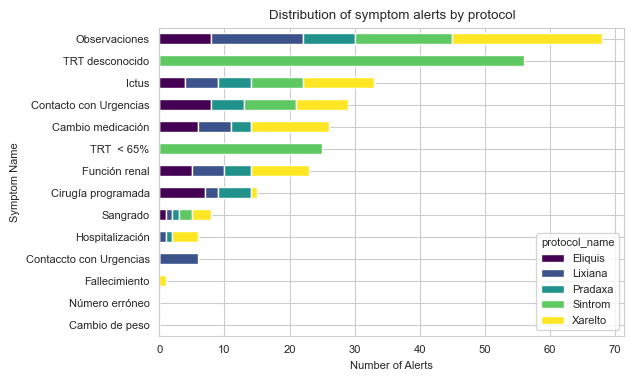

In [307]:
unstacked_df = protocols_df.groupby(['name', 'protocol_name']).sum()['Number of Alerts'].unstack(level='protocol_name')

# Sort the DataFrame based on the total number of alerts for each symptom
sorted_df = unstacked_df.assign(Total=unstacked_df.sum(axis=1)).sort_values(by='Total', ascending=True).drop('Total', axis=1)

# Plotting with pandas and matplotlib, but with Seaborn styling
sorted_df.plot(kind='barh', stacked=True, colormap='viridis')
plt.title('Distribution of symptom alerts by protocol')
plt.xlabel('Number of Alerts')
plt.ylabel('Symptom Name')
plt.show()

In [308]:
intervention_protocol_map = dict(zip(df_conversations['conversationId'], df_conversations['protocolName']))
df_interventions['protocolName'] = df_interventions['conversationId'].map(intervention_protocol_map)

df_interventions = df_interventions[df_interventions['protocolName'].isin(clinical_protocols)]
len(df_interventions)

/var/folders/pz/qj_4jm0j2fs1026kt8lfr3200000gn/T/ipykernel_3345/2513688559.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interventions['protocolName'] = df_interventions['conversationId'].map(intervention_protocol_map)


50

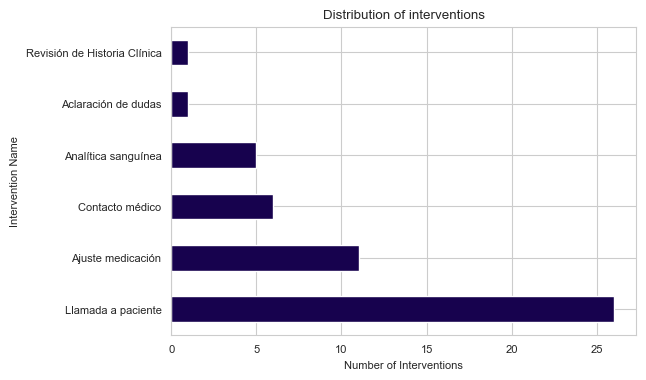

In [309]:
df_interventions['name'].value_counts().plot(kind='barh')

plt.title('Distribution of interventions')
plt.xlabel('Number of Interventions')
plt.ylabel('Intervention Name')
plt.show()

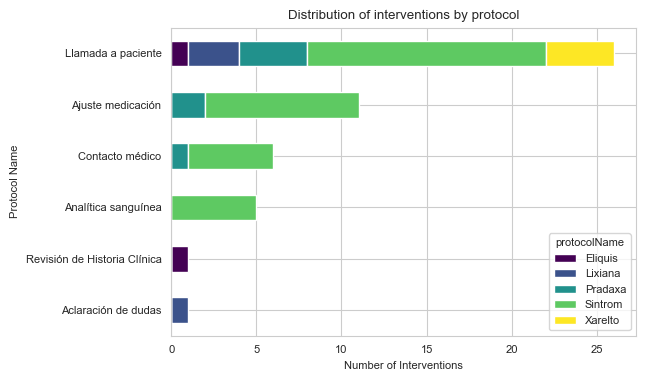

In [310]:
df_interventions[['name', 'value', 'protocolName']].groupby(['name', 'protocolName']).count()['value']

unstacked_df = df_interventions[['name', 'value', 'protocolName']].groupby(['name', 'protocolName']).count()['value'].unstack(level='protocolName')

# Sort the DataFrame based on the total number of alerts for each symptom
sorted_df = unstacked_df.assign(Total=unstacked_df.sum(axis=1)).sort_values(by='Total', ascending=True).drop('Total', axis=1)

# Plotting with pandas and matplotlib, but with Seaborn styling
sorted_df.plot(kind='barh', stacked=True, colormap='viridis')
plt.title('Distribution of interventions by protocol')
plt.xlabel('Number of Interventions')
plt.ylabel('Protocol Name')
plt.show()

## Specific Protocol Analysis

In [311]:
#protocol_name = protocols[0]
protocol_name = 'Sintrom'

In [312]:
df_interventions_matrix, interventions = generate_interventions_matrix_dataframe(df_interventions)

In [358]:
statistics, df, alerts, interventions, df_symptoms, log_changes = get_protocol_statistics(df_conversations, df_interventions_matrix, interventions, protocol_name, with_low=True)

In [314]:
print("Total number of unique patients: ", df['patientId'].nunique())

Total number of unique patients:  19


In [315]:
print("Total number of patients reached: ", df[df['answered'] == True]['patientId'].nunique())

Total number of patients reached:  19


In [316]:
print("Total number of followups: ", len(df))

Total number of followups:  147


In [317]:
print("Total number of attempted calls: ", df['repetition'].sum() + len(df))

Total number of attempted calls:  216


In [318]:
total_answered = len(df[df['answered'] == True])
print("Total number of answered calls: ", total_answered)

Total number of answered calls:  133


In [319]:
total_completed = len(df[df['completed'] == True])
print("Total number of completed calls: ", total_completed)

Total number of completed calls:  128


In [320]:
print("Total number of alerts: ", df['alertNumber'].sum())

Total number of alerts:  114


In [321]:
print("Total number of conversations with alerts: ", len(df[df['alertNumber'] > 0]))

Total number of conversations with alerts:  85


In [322]:
print("Total number of conversations without alerts: ", len(df[(df['completed'] == True) & (df['alertNumber'] == 0)]))

Total number of conversations without alerts:  44


In [323]:
print("Total number of interventions: ", df['interventionNumber'].sum())

Total number of interventions:  33


In [324]:
total_alert_conversations = len(df[df['alertNumber']>0])
total_alert_intervention_conversations = len(df[(df['alertNumber']>0) & (df['interventionNumber']>0)])

try:
    prioritisation_accuracy = total_alert_intervention_conversations / total_alert_conversations
except ZeroDivisionError:
    prioritisation_accuracy = float('nan')

print("Prioritization accuracy: ", prioritisation_accuracy)

Prioritization accuracy:  0.17647058823529413


### General Visualizations

In [325]:
# Setting up a general plot style for consistency
# It doesn't fully work yet! :)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 8         

sns.set_palette('dark:#17024e_r') 

plt.rcParams['lines.linewidth'] = 2  
plt.rcParams['axes.grid'] = True    
plt.rcParams['axes.facecolor'] = 'white' 
plt.rcParams['figure.figsize'] = [6, 4]  

sns.set_style('whitegrid')

pd.set_option('plotting.backend', 'matplotlib')

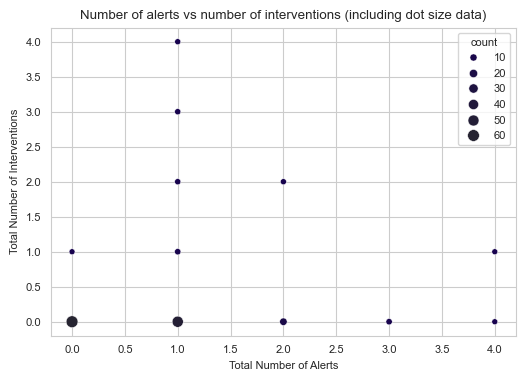

In [326]:
df_alert_intervention = df.groupby(['alertNumber', 'interventionNumber']).size().reset_index(name='count')

sns.set_style('whitegrid')

sns.scatterplot(x='alertNumber', y='interventionNumber', data=df_alert_intervention, size='count', hue='count', palette='dark:#17024e_r')

plt.title('Number of alerts vs number of interventions (including dot size data)')
plt.xlabel('Total Number of Alerts')
plt.ylabel('Total Number of Interventions')

plt.show()

In [327]:
df_patients = df.groupby('patientId').sum()

# Scatterplot number of total alerts vs intervention number per patient

sns.scatterplot(x='alertNumber', y='interventionNumber', data=df_patients)

plt.title('Number of total alerts vs intervention number per patient')
plt.xlabel('Total Number of Alerts')
plt.ylabel('Total Number of Interventions')

plt.show()

### Strategy

<pre>
- Which alerts are directly related to actions on the hospital side, and which are not?
    - 1) What alerts are triggered the most? What interventions are most common?
    - 2) Are alerts correlated between eachother?
    - 3) Is there direct correlation between alerts and interventions?
    - 4) Descriptive analysis: Classify alerts according to their impact in decision making
    
- Combined alerts
    - 5) Focused alert analysis: What alerts are unharmful when triggered alone?
    - 6) Focused alert set analysis: Which combinations of unharmful alerts are significant?

- Pattern recognition
    - 7) Macroanalysis: Are there any alert patterns in conversations with high intervention occurence?

- Response time
    - 8) Alert number vs Response time
</pre>

#### 1) What symptoms are triggered the most?

In [328]:
df[alerts].sum().plot(kind='bar')
plt.title('Distribution of symptom alerts')

plt.show()

In [329]:
df[interventions].sum().plot(kind='bar')
plt.title('Distribution of interventions')

plt.show()

#### 2) Are symptoms correlated between eachoter?

In [330]:
# Setting up a general plot style for consistency
# It doesn't fully work yet! :)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 8         

sns.set_palette('dark:#17024e_r') 

plt.rcParams['lines.linewidth'] = 2  
plt.rcParams['axes.grid'] = True    
plt.rcParams['axes.facecolor'] = 'white' 
plt.rcParams['figure.figsize'] = [12, 8]  

sns.set_style('dark')

pd.set_option('plotting.backend', 'matplotlib')

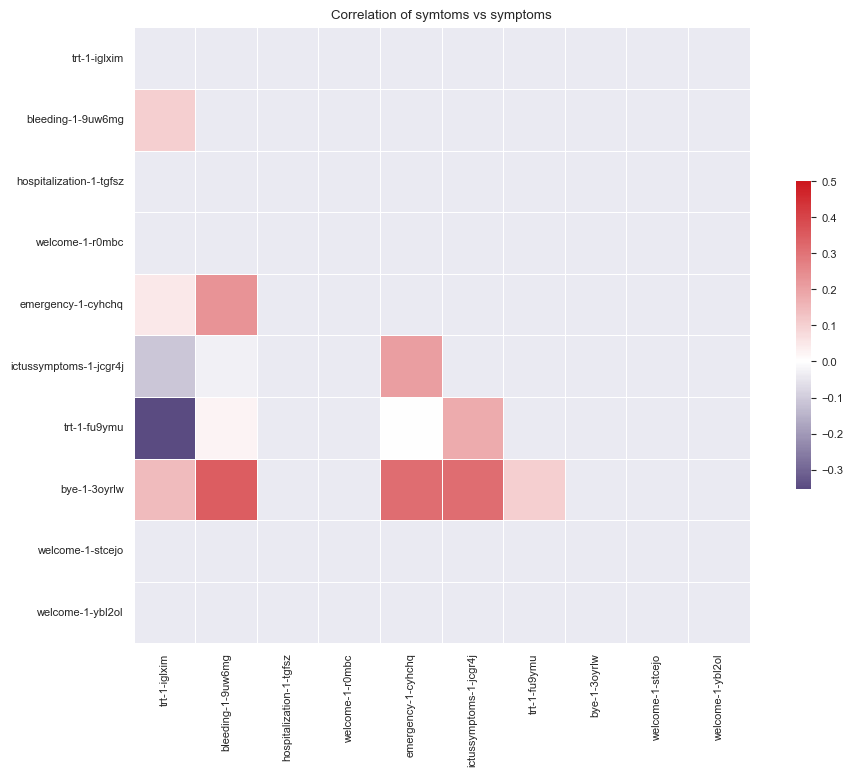

In [331]:
from matplotlib.colors import LinearSegmentedColormap

corr_x_df = df[alerts].corr()

mask = np.triu(np.ones_like(corr_x_df, dtype=bool))

f, ax = plt.subplots()

cmap = LinearSegmentedColormap.from_list("custom", ["#17024e", "white", "#cd181e"])

sns.heatmap(corr_x_df, annot=False, mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation of symtoms vs symptoms')

plt.show()

#### 3) Is there direct correlation between symptoms and interventions?

In [332]:
x = df[alerts].to_numpy()
y = df[interventions].to_numpy()

In [333]:
N_ALERTS = len(alerts)
N_INTERVENTIONS = len(interventions)

correlations = np.zeros((N_ALERTS, N_INTERVENTIONS))

for i in range(N_ALERTS):  # For each symptom
    for j in range(N_INTERVENTIONS):  # For each action
        # Compute the Phi coefficient
        correlation, p_value = pearsonr(x[:, i], y[:, j])
        correlations[i, j] = correlation

/Users/davidcastellotejer/Documents/PythonScripts/Analytics/analytics/lib/python3.12/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [334]:
sns.heatmap(correlations, annot=True, cmap=cmap, center=0, linewidths=.5, cbar_kws={"shrink": .5},
            xticklabels=interventions, yticklabels=alerts)

plt.title('Alert-Intervention Correlation Matrix')
plt.xlabel('Intervention')
plt.ylabel('Alert')

plt.show()

#### 4) Descriptive analysis

In [335]:
frequencies_df = pd.DataFrame()

for symptom in alerts:  
    frequencies = []

    for intervention in interventions:
        frequency = df[df[symptom] > 0][intervention].mean()
        frequencies.append(frequency)

    frequencies_df[symptom] = frequencies

frequencies_df = frequencies_df.transpose()

frequencies_df.columns = interventions

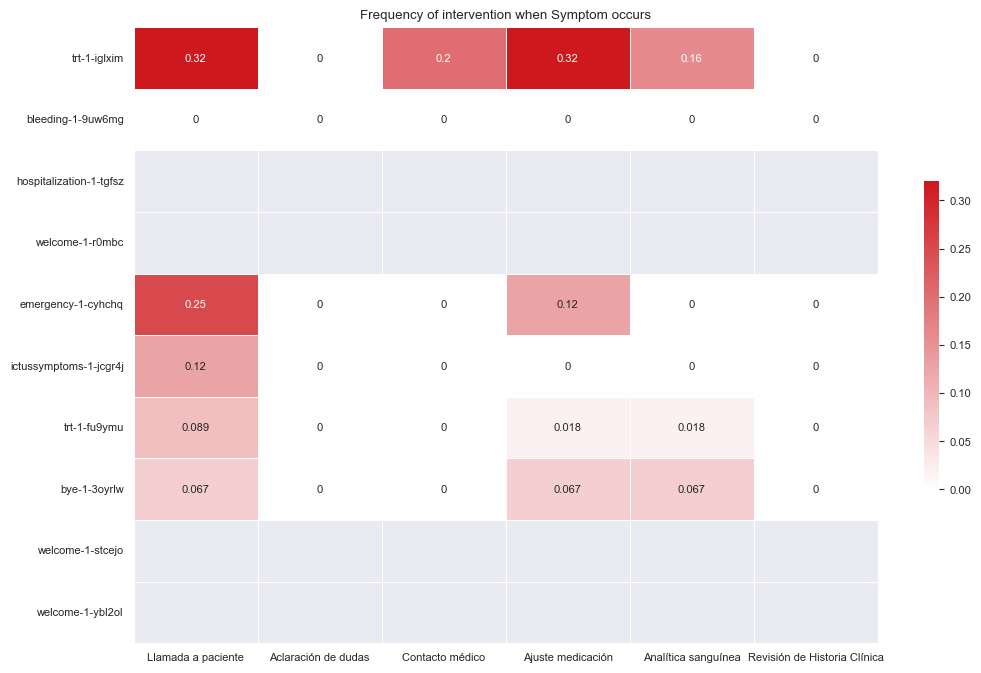

In [336]:
sns.heatmap(frequencies_df, annot=True, cmap=cmap, center=0,linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Frequency of intervention when Symptom occurs')

plt.show()

In [337]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

x = df[interventions].sum()
y = df[alerts].sum()

# Sort 'y' in descending order and get the sorted indices
y_sorted = y.sort_values(ascending=False)

# Map original indices to new positions
index_mapping = {old_index: new_index for new_index, old_index in enumerate(y_sorted.index)}

# Reorder the rows in 'frequencies_df' according to the new index positions
frequencies_df_sorted = frequencies_df.reindex(index_mapping)

# Set up the matplotlib figure and axes
fig, ax = plt.subplots()

# Create the heatmap with proper formatting for float numbers
sns.heatmap(frequencies_df_sorted, annot=True, fmt=".2f", cmap=cmap, cbar=False, center=0,linewidths=.5)

# Create the side histogram for the y-axis
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes('right', size='20%', pad='2%')
sns.barplot(x=y_sorted, y=np.arange(len(y_sorted)), ax=cax, color="darkblue", orient='horizontal')
cax.set_yticks([])
cax.set_xticks([])

# Create the top histogram for the x-axis
tax = ax_divider.append_axes('top', size='20%', pad='2%')
sns.barplot(x=np.arange(len(x)), y=x, ax=tax, color="darkblue")
tax.set_xticks([])
tax.set_yticks([])

# Rotate the tick labels for the heatmap if necessary
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0)

# Adjust layout to make room for the color bar and histograms
fig.tight_layout(rect=[0, 0, 0.9, 1])

# Customize the side histogram's axes (cax)
for spine in cax.spines.values():
    spine.set_visible(False)
cax.set_ylabel('')
cax.set_xlabel('')

# Customize the top histogram's axes (tax)
for spine in tax.spines.values():
    spine.set_visible(False)
tax.set_ylabel('')

# Show the plot
plt.show()

In [338]:
df_symptoms_analysis, log_changes = get_protocol_alert_analysis(df_conversations, df_interventions, protocol_name, with_low=True)

### 5) Focused symptom analysis

This algorithm computes the average intervention occurence for cases where a certain alert exists and up to T (T>1) other alerts (noise tolerance).

We are using T = 3

In [339]:
def get_focused_analysis(symptoms_analysis_dataframe: pd.DataFrame(), matrix_mataframe: pd.DataFrame(), alerts: list, T=3):
    
    matrix_mataframe['individualAlerts'] = matrix_mataframe[alerts].apply(lambda row: sum(row != 0), axis=1)
    
    frequencies = []
    prioritization = []
    supports = []

    df_focused = matrix_mataframe[(matrix_mataframe['individualAlerts'] > 0) & (matrix_mataframe['individualAlerts'] < T+1)]

    for symptom in alerts:
        score = df_focused[(df_focused[symptom] > 0)]['interventionNumber'].mean()
        frequencies.append(score)

        total = len(df_focused[(df_focused[symptom] > 0)])
        actioned = len(df_focused[(df_focused[symptom] > 0)][df_focused['interventionNumber'] > 0])
        if total != 0:
            prioritization.append(actioned / total)
        else:
            prioritization.append(0)

        # Counting the number of rows used for the mean calculation
        support_count = len(df_focused[(df_focused[symptom] > 0)])
        supports.append(support_count)

    focused_analysis_df = pd.DataFrame({
        'frequency score (focused)': frequencies,
        'prioritization score (focused)': prioritization,
        'Support': supports
    }, index=alerts)

    symptoms_analysis_dataframe = pd.merge(symptoms_analysis_dataframe, focused_analysis_df, left_on='id', right_index=True, how='outer').sort_values('Number of Alerts', ascending=False)
    
    return symptoms_analysis_dataframe


In [340]:
df_symptoms_analysis = get_focused_analysis(df_symptoms_analysis, df, alerts, T=3)

/var/folders/pz/qj_4jm0j2fs1026kt8lfr3200000gn/T/ipykernel_3345/1320573308.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  actioned = len(df_focused[(df_focused[symptom] > 0)][df_focused['interventionNumber'] > 0])
/var/folders/pz/qj_4jm0j2fs1026kt8lfr3200000gn/T/ipykernel_3345/1320573308.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  actioned = len(df_focused[(df_focused[symptom] > 0)][df_focused['interventionNumber'] > 0])
/var/folders/pz/qj_4jm0j2fs1026kt8lfr3200000gn/T/ipykernel_3345/1320573308.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  actioned = len(df_focused[(df_focused[symptom] > 0)][df_focused['interventionNumber'] > 0])
/var/folders/pz/qj_4jm0j2fs1026kt8lfr3200000gn/T/ipykernel_3345/1320573308.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  actioned = len(df_focused[(df_focused[symptom] > 0)][df_focused['interventionNumber'

### First results

In [341]:
def categorize(row):
    if pd.isna(row['prioritisation score']):
        return 'UNKNOWN'
    average = (row['frequency score'] + row['prioritisation score']*3)/4
    if average > 0.79:
        return 'HIGH'
    elif average >= 0.5:
        return 'MEDIUM'
    elif average >= 0.4:
        return 'LOW'
    else:
        return 'DEACTIVATE'

df_symptoms_analysis['Recomendation'] = df_symptoms_analysis.apply(categorize, axis=1)
df_symptoms_analysis[~(df_symptoms_analysis['Recomendation'] == 'UNKNOWN')][(df_symptoms_analysis['Recomendation'] != df_symptoms_analysis['severity'])].sort_values(by='Number of Alerts', ascending=False)

/var/folders/pz/qj_4jm0j2fs1026kt8lfr3200000gn/T/ipykernel_3345/586118626.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_symptoms_analysis[~(df_symptoms_analysis['Recomendation'] == 'UNKNOWN')][(df_symptoms_analysis['Recomendation'] != df_symptoms_analysis['severity'])].sort_values(by='Number of Alerts', ascending=False)


name                      id severity  frequency score  \
6         TRT desconocido            trt-1-fu9ymu      LOW            0.125   
0              TRT  < 65%            trt-1-iglxim     HIGH            1.000   
7           Observaciones            bye-1-3oyrlw      LOW            0.200   
4  Contacto con Urgencias      emergency-1-cyhchq   MEDIUM            0.375   
5                   Ictus  ictussymptoms-1-jcgr4j     HIGH            0.125   
1                Sangrado       bleeding-1-9uw6mg     HIGH            0.000   

   prioritisation score  Number of Alerts  frequency score (focused)  \
6              0.107143                56                   0.109091   
0              0.360000                25                   1.041667   
7              0.133333                15                   0.153846   
4              0.250000                 8                   0.333333   
5              0.125000                 8                   0.000000   
1              0.000000                 2                   0.000000   

   prioritization score (focused)  Support Recomendation  
6                        0.090909       55    DEACTIVATE  
0                        0.375000       24        MEDIUM  
7                        0.076923       13    DEACTIVATE  
4                        0.166667        6    DEACTIVATE  
5                        0.000000        7    DEACTIVATE  
1                        0.000000        1    DEACTIVATE

### Firebase alert mapping

In [342]:
import firebase_admin
from firebase_admin import firestore, credentials

In [359]:
def get_id_alert_map(key, item):
    operator_value = item['alertType'].get('operator', 'qualitative')
    threshold_value = item['alertType'].get('threshold', '')
    type_number = item['alertType'].get('typeNumber', '')

    if type_number == 2:
        type = 'absolute value'
    elif type_number == 3:
        type = 'comparison'
    else:
        type = str(type_number)

    return str(operator_value) + ' ' + str(threshold_value) + ' ' + type


def map_ids(conversations_dataframe: pd.DataFrame(), symptoms_analysis_dataframe: pd.DataFrame(), protocol):

    path = "tucuvi.json"

    # Starting First Firebase Client
    cred_dev = credentials.Certificate(path)
    app_dev = firebase_admin.initialize_app(cred_dev, name="app")
    db_dev = firestore.client(app_dev)

    protocol_conversations_dataframe = conversations_dataframe[conversations_dataframe['protocolName'] == protocol]

    CLIENT_ID = protocol_conversations_dataframe['clientId'].iloc[0]
    WORK_UNIT_ID = protocol_conversations_dataframe['workUnitIds'].iloc[0][0]
    MODULE_ID = protocol_conversations_dataframe['moduleId'].iloc[0]
    PROTOCOL_ID = protocol_conversations_dataframe['protocolId'].iloc[0]

    module_doc = db_dev.collection("client-schema").document(CLIENT_ID).collection("workUnits").document(WORK_UNIT_ID).collection("modules").document(MODULE_ID).get().to_dict()
    alerts_obj = module_doc["protocols"][PROTOCOL_ID]["alerts"]["flows"]

    id_alert_map = {item['id']: get_id_alert_map(key, item) 
                for key in alerts_obj 
                for item in alerts_obj[key]}

    symptoms_analysis_dataframe['id'] = symptoms_analysis_dataframe['id'].map(id_alert_map)

    firebase_admin.delete_app(app_dev)

    return symptoms_analysis_dataframe, id_alert_map

In [360]:
df_symptoms_analysis_mapped, id_alert_map = map_ids(df_conversations, df_symptoms_analysis.copy(), protocol_name)

In [345]:
df_symptoms_analysis_mapped[~(df_symptoms_analysis_mapped['Recomendation'] == 'UNKNOWN')][(df_symptoms_analysis_mapped['Recomendation'] != df_symptoms_analysis_mapped['severity'])].sort_values(by='Number of Alerts', ascending=False)

/var/folders/pz/qj_4jm0j2fs1026kt8lfr3200000gn/T/ipykernel_3345/4260642308.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_symptoms_analysis_mapped[~(df_symptoms_analysis_mapped['Recomendation'] == 'UNKNOWN')][(df_symptoms_analysis_mapped['Recomendation'] != df_symptoms_analysis_mapped['severity'])].sort_values(by='Number of Alerts', ascending=False)


name              id severity  frequency score  \
6         TRT desconocido  qualitative  1      LOW            0.125   
0              TRT  < 65%  qualitative  1     HIGH            1.000   
7           Observaciones  qualitative  1      LOW            0.200   
4  Contacto con Urgencias  qualitative  1   MEDIUM            0.375   
5                   Ictus  qualitative  1     HIGH            0.125   
1                Sangrado  qualitative  1     HIGH            0.000   

   prioritisation score  Number of Alerts  frequency score (focused)  \
6              0.107143                56                   0.109091   
0              0.360000                25                   1.041667   
7              0.133333                15                   0.153846   
4              0.250000                 8                   0.333333   
5              0.125000                 8                   0.000000   
1              0.000000                 2                   0.000000   

   prioritization score (focused)  Support Recomendation  
6                        0.090909       55    DEACTIVATE  
0                        0.375000       24        MEDIUM  
7                        0.076923       13    DEACTIVATE  
4                        0.166667        6    DEACTIVATE  
5                        0.000000        7    DEACTIVATE  
1                        0.000000        1    DEACTIVATE

### 6) Focused symptom set analysis

In [346]:
unharmful_symptoms = list(df_symptoms_analysis[(df_symptoms_analysis['Recomendation'] == 'LOW') | (df_symptoms_analysis['Recomendation'] == 'DEACTIVATE')]['id'])
unharmful_symptoms

['trt-1-fu9ymu',
 'bye-1-3oyrlw',
 'emergency-1-cyhchq',
 'ictussymptoms-1-jcgr4j',
 'bleeding-1-9uw6mg']

Define set size (S) to study the possible combinations of unharmful symptoms.

In [347]:
combined_alerts = pd.DataFrame()

In [348]:
def isSet(dataframe, set):

    is_set =[]

    for index, row in dataframe.iterrows():
        c = 0
        r = 0

        for alert in alerts:
            if (alert in set) & (row[alert] > 0):
                c += 1

        if c == len(set):
            r = 1
        
        is_set.append(r)

    return is_set

In [349]:
S = 2
T = 3

# Pre-compute all combinations
symptom_sets = list(itertools.combinations(unharmful_symptoms, S))

# Initialize lists for frequencies, supports, and p_scores
frequencies = []
supports = []
p_scores = []

# Iterate over each symptom set
for symptom_set in symptom_sets:
    # Assume isSet is a function that returns a boolean Series
    is_set_series = isSet(df, symptom_set)

    # Apply the conditions using boolean indexing
    filtered_df = df[is_set_series & (df['individualAlerts'] < T + S + 1)]

    # Calculate the mean, support count, and p_score
    mean_intervention = filtered_df['interventionNumber'].mean()
    support_count = len(filtered_df)
    p_score = (filtered_df['interventionNumber'] > 0).sum() / len(filtered_df) if len(filtered_df) > 0 else 0

    # Append results to lists
    frequencies.append(mean_intervention)
    supports.append(support_count)
    p_scores.append(p_score)

# Create the DataFrame
frequencies_df = pd.DataFrame({
    'Average Focused Set Interventions': frequencies,
    'Focused Set Prioritization Score': p_scores,
    'Support': supports
}, index=symptom_sets)


/var/folders/pz/qj_4jm0j2fs1026kt8lfr3200000gn/T/ipykernel_3345/466603514.py:18: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  filtered_df = df[is_set_series & (df['individualAlerts'] < T + S + 1)]


In [350]:
frequencies_df.sort_values(by='Average Focused Set Interventions', ascending=False).head(15)

Average Focused Set Interventions  \
(emergency-1-cyhchq, ictussymptoms-1-jcgr4j)                           0.500000   
(trt-1-fu9ymu, bye-1-3oyrlw)                                           0.375000   
(trt-1-fu9ymu, emergency-1-cyhchq)                                     0.333333   
(bye-1-3oyrlw, emergency-1-cyhchq)                                     0.250000   
(bye-1-3oyrlw, ictussymptoms-1-jcgr4j)                                 0.250000   
(trt-1-fu9ymu, ictussymptoms-1-jcgr4j)                                 0.166667   
(trt-1-fu9ymu, bleeding-1-9uw6mg)                                      0.000000   
(bye-1-3oyrlw, bleeding-1-9uw6mg)                                      0.000000   
(emergency-1-cyhchq, bleeding-1-9uw6mg)                                0.000000   
(ictussymptoms-1-jcgr4j, bleeding-1-9uw6mg)                                 NaN   

                                              Focused Set Prioritization Score  \
(emergency-1-cyhchq, ictussymptoms-1-jcgr4j)                          0.500000   
(trt-1-fu9ymu, bye-1-3oyrlw)                                          0.250000   
(trt-1-fu9ymu, emergency-1-cyhchq)                                    0.333333   
(bye-1-3oyrlw, emergency-1-cyhchq)                                    0.250000   
(bye-1-3oyrlw, ictussymptoms-1-jcgr4j)                                0.250000   
(trt-1-fu9ymu, ictussymptoms-1-jcgr4j)                                0.166667   
(trt-1-fu9ymu, bleeding-1-9uw6mg)                                     0.000000   
(bye-1-3oyrlw, bleeding-1-9uw6mg)                                     0.000000   
(emergency-1-cyhchq, bleeding-1-9uw6mg)                               0.000000   
(ictussymptoms-1-jcgr4j, bleeding-1-9uw6mg)                           0.000000   

                                              Support  
(emergency-1-cyhchq, ictussymptoms-1-jcgr4j)        2  
(trt-1-fu9ymu, bye-1-3oyrlw)                        8  
(trt-1-fu9ymu, emergency-1-cyhchq)                  3  
(bye-1-3oyrlw, emergency-1-cyhchq)                  4  
(bye-1-3oyrlw, ictussymptoms-1-jcgr4j)              4  
(trt-1-fu9ymu, ictussymptoms-1-jcgr4j)              6  
(trt-1-fu9ymu, bleeding-1-9uw6mg)                   1  
(bye-1-3oyrlw, bleeding-1-9uw6mg)                   2  
(emergency-1-cyhchq, bleeding-1-9uw6mg)             1  
(ictussymptoms-1-jcgr4j, bleeding-1-9uw6mg)         0

In [351]:
combined_alerts = pd.concat([combined_alerts, frequencies_df])

In [352]:
S = 3
T = 3

# Pre-compute all combinations
symptom_sets = list(itertools.combinations(unharmful_symptoms, S))

# Initialize lists for frequencies, supports, and p_scores
frequencies = []
supports = []
p_scores = []

# Iterate over each symptom set
for symptom_set in symptom_sets:
    # Assume isSet is a function that returns a boolean Series
    is_set_series = isSet(df, symptom_set)

    # Apply the conditions using boolean indexing
    filtered_df = df[is_set_series & (df['individualAlerts'] < T + S + 1)]

    # Calculate the mean, support count, and p_score
    mean_intervention = filtered_df['interventionNumber'].mean()
    support_count = len(filtered_df)
    p_score = (filtered_df['interventionNumber'] > 0).sum() / len(filtered_df) if len(filtered_df) > 0 else 0

    # Append results to lists
    frequencies.append(mean_intervention)
    supports.append(support_count)
    p_scores.append(p_score)

# Create the DataFrame
frequencies_df = pd.DataFrame({
    'Average Focused Set Interventions': frequencies,
    'Focused Set Prioritization Score': p_scores,
    'Support': supports
}, index=symptom_sets)

/var/folders/pz/qj_4jm0j2fs1026kt8lfr3200000gn/T/ipykernel_3345/2951669301.py:18: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  filtered_df = df[is_set_series & (df['individualAlerts'] < T + S + 1)]


In [353]:
frequencies_df.sort_values(by='Average Focused Set Interventions', ascending=False).head(20)

Average Focused Set Interventions  \
(trt-1-fu9ymu, bye-1-3oyrlw, emergency-1-cyhchq)                             1.000000   
(trt-1-fu9ymu, emergency-1-cyhchq, ictussymptom...                           1.000000   
(bye-1-3oyrlw, emergency-1-cyhchq, ictussymptom...                           0.500000   
(trt-1-fu9ymu, bye-1-3oyrlw, ictussymptoms-1-jc...                           0.333333   
(trt-1-fu9ymu, bye-1-3oyrlw, bleeding-1-9uw6mg)                              0.000000   
(bye-1-3oyrlw, emergency-1-cyhchq, bleeding-1-9...                           0.000000   
(trt-1-fu9ymu, emergency-1-cyhchq, bleeding-1-9...                                NaN   
(trt-1-fu9ymu, ictussymptoms-1-jcgr4j, bleeding...                                NaN   
(bye-1-3oyrlw, ictussymptoms-1-jcgr4j, bleeding...                                NaN   
(emergency-1-cyhchq, ictussymptoms-1-jcgr4j, bl...                                NaN   

                                                    Focused Set Prioritization Score  \
(trt-1-fu9ymu, bye-1-3oyrlw, emergency-1-cyhchq)                            1.000000   
(trt-1-fu9ymu, emergency-1-cyhchq, ictussymptom...                          1.000000   
(bye-1-3oyrlw, emergency-1-cyhchq, ictussymptom...                          0.500000   
(trt-1-fu9ymu, bye-1-3oyrlw, ictussymptoms-1-jc...                          0.333333   
(trt-1-fu9ymu, bye-1-3oyrlw, bleeding-1-9uw6mg)                             0.000000   
(bye-1-3oyrlw, emergency-1-cyhchq, bleeding-1-9...                          0.000000   
(trt-1-fu9ymu, emergency-1-cyhchq, bleeding-1-9...                          0.000000   
(trt-1-fu9ymu, ictussymptoms-1-jcgr4j, bleeding...                          0.000000   
(bye-1-3oyrlw, ictussymptoms-1-jcgr4j, bleeding...                          0.000000   
(emergency-1-cyhchq, ictussymptoms-1-jcgr4j, bl...                          0.000000   

                                                    Support  
(trt-1-fu9ymu, bye-1-3oyrlw, emergency-1-cyhchq)          1  
(trt-1-fu9ymu, emergency-1-cyhchq, ictussymptom...        1  
(bye-1-3oyrlw, emergency-1-cyhchq, ictussymptom...        2  
(trt-1-fu9ymu, bye-1-3oyrlw, ictussymptoms-1-jc...        3  
(trt-1-fu9ymu, bye-1-3oyrlw, bleeding-1-9uw6mg)           1  
(bye-1-3oyrlw, emergency-1-cyhchq, bleeding-1-9...        1  
(trt-1-fu9ymu, emergency-1-cyhchq, bleeding-1-9...        0  
(trt-1-fu9ymu, ictussymptoms-1-jcgr4j, bleeding...        0  
(bye-1-3oyrlw, ictussymptoms-1-jcgr4j, bleeding...        0  
(emergency-1-cyhchq, ictussymptoms-1-jcgr4j, bl...        0

In [354]:
combined_alerts = pd.concat([combined_alerts, frequencies_df])

In [355]:
combined_alerts = combined_alerts[combined_alerts['Average Focused Set Interventions'] > 0.49]

In [357]:
combined_alerts

Average Focused Set Interventions  \
(emergency-1-cyhchq, ictussymptoms-1-jcgr4j)                                      0.5   
(trt-1-fu9ymu, bye-1-3oyrlw, emergency-1-cyhchq)                                  1.0   
(trt-1-fu9ymu, emergency-1-cyhchq, ictussymptom...                                1.0   
(bye-1-3oyrlw, emergency-1-cyhchq, ictussymptom...                                0.5   

                                                    Focused Set Prioritization Score  \
(emergency-1-cyhchq, ictussymptoms-1-jcgr4j)                                     0.5   
(trt-1-fu9ymu, bye-1-3oyrlw, emergency-1-cyhchq)                                 1.0   
(trt-1-fu9ymu, emergency-1-cyhchq, ictussymptom...                               1.0   
(bye-1-3oyrlw, emergency-1-cyhchq, ictussymptom...                               0.5   

                                                    Support  
(emergency-1-cyhchq, ictussymptoms-1-jcgr4j)              2  
(trt-1-fu9ymu, bye-1-3oyrlw, emergency-1-cyhchq)          1  
(trt-1-fu9ymu, emergency-1-cyhchq, ictussymptom...        1  
(bye-1-3oyrlw, emergency-1-cyhchq, ictussymptom...        2

In [361]:
id_to_name = pd.Series(df_symptoms['name'].values, index=df_symptoms['id']).to_dict()

# Step 2 and 3: Function to map and concatenate names
def map_ids_to_names(ids):
    # Handle both single ID and tuples of IDs
    if isinstance(ids, tuple):
        return '\n+\n'.join(id_to_name[id] for id in ids)
    else:
        return id_to_name[ids]

def map_ids_to_descriptions(ids):
    # Handle both single ID and tuples of IDs
    if isinstance(ids, tuple):
        return '\n+\n'.join(id_alert_map[id] for id in ids)
    else:
        return id_alert_map[ids]

# Step 4: Create the new column
combined_alerts['concatenated_names'] = combined_alerts.index.map(map_ids_to_names)
combined_alerts['concatenated_descriptions'] = combined_alerts.index.map(map_ids_to_descriptions)

combined_alerts

Average Focused Set Interventions  \
(emergency-1-cyhchq, ictussymptoms-1-jcgr4j)                                      0.5   
(trt-1-fu9ymu, bye-1-3oyrlw, emergency-1-cyhchq)                                  1.0   
(trt-1-fu9ymu, emergency-1-cyhchq, ictussymptom...                                1.0   
(bye-1-3oyrlw, emergency-1-cyhchq, ictussymptom...                                0.5   

                                                    Focused Set Prioritization Score  \
(emergency-1-cyhchq, ictussymptoms-1-jcgr4j)                                     0.5   
(trt-1-fu9ymu, bye-1-3oyrlw, emergency-1-cyhchq)                                 1.0   
(trt-1-fu9ymu, emergency-1-cyhchq, ictussymptom...                               1.0   
(bye-1-3oyrlw, emergency-1-cyhchq, ictussymptom...                               0.5   

                                                    Support  \
(emergency-1-cyhchq, ictussymptoms-1-jcgr4j)              2   
(trt-1-fu9ymu, bye-1-3oyrlw, emergency-1-cyhchq)          1   
(trt-1-fu9ymu, emergency-1-cyhchq, ictussymptom...        1   
(bye-1-3oyrlw, emergency-1-cyhchq, ictussymptom...        2   

                                                                                   concatenated_names  \
(emergency-1-cyhchq, ictussymptoms-1-jcgr4j)                         Contacto con Urgencias\n+\nIctus   
(trt-1-fu9ymu, bye-1-3oyrlw, emergency-1-cyhchq)    TRT desconocido\n+\nObservaciones\n+\nContacto...   
(trt-1-fu9ymu, emergency-1-cyhchq, ictussymptom...  TRT desconocido\n+\nContacto con Urgencias\n+\...   
(bye-1-3oyrlw, emergency-1-cyhchq, ictussymptom...  Observaciones\n+\nContacto con Urgencias\n+\nI...   

                                                                            concatenated_descriptions  
(emergency-1-cyhchq, ictussymptoms-1-jcgr4j)                        qualitative  1\n+\nqualitative  1  
(trt-1-fu9ymu, bye-1-3oyrlw, emergency-1-cyhchq)    qualitative  1\n+\nqualitative  1\n+\nqualitat...  
(trt-1-fu9ymu, emergency-1-cyhchq, ictussymptom...  qualitative  1\n+\nqualitative  1\n+\nqualitat...  
(bye-1-3oyrlw, emergency-1-cyhchq, ictussymptom...  qualitative  1\n+\nqualitative  1\n+\nqualitat...

In [362]:
with pd.ExcelWriter('combined_alerts.xlsx') as writer:
    combined_alerts.to_excel(writer, sheet_name='combined_alerts', index=False)

#### 7) Macroanalysis

In [ ]:
df_with_index = df.set_index('interventionNumber')

sorted_df = df_with_index.sort_index(ascending=False)

plt.figure(figsize=(8, 6)) 
sns.heatmap(sorted_df[alerts], cmap="Blues", cbar=False)

plt.title("Binary Matrix Heatmap Ordered by Intervention Number")
plt.xlabel("Symptoms")
plt.ylabel("Intervention Number")
plt.show()

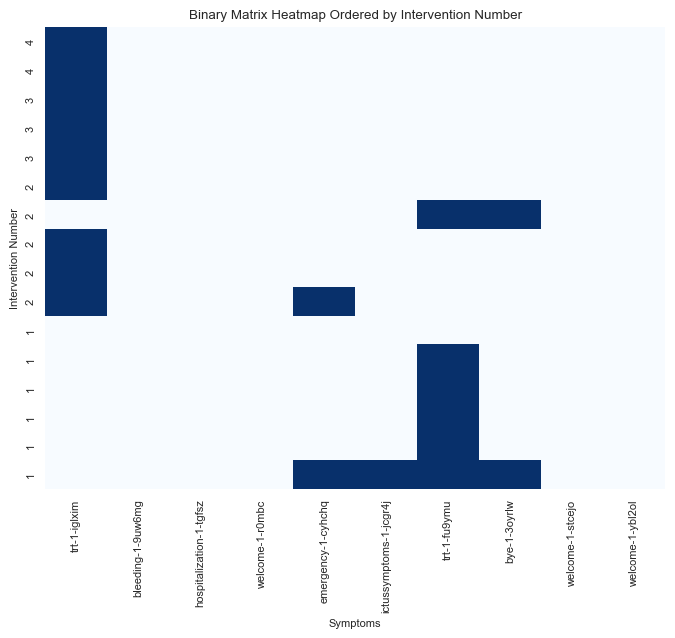

In [ ]:
df_with_index = df[df['interventionNumber'] > 0].set_index('interventionNumber')

sorted_df = df_with_index.sort_index(ascending=False)

plt.figure(figsize=(8, 6)) 
sns.heatmap(sorted_df[alerts], cmap="Blues", cbar=False)

plt.title("Binary Matrix Heatmap Ordered by Intervention Number")
plt.xlabel("Symptoms")
plt.ylabel("Intervention Number")
plt.show()

### Response Time

In [380]:
def get_protocols_response_time(conversations_dataframe: pd.DataFrame(), protocols):

    if isinstance(protocols, str):
        protocols = [protocols]
    
    df_conversations_protocol = conversations_dataframe[conversations_dataframe['protocolName'].isin(protocols)]

    df_responsetime = df_conversations_protocol[df_conversations_protocol['timeToConvert'].notnull()]
    df_responsetime['timeToConvert'] = (df_responsetime['timeToConvert']/60).astype(int)

    return df_responsetime

/var/folders/pz/qj_4jm0j2fs1026kt8lfr3200000gn/T/ipykernel_3345/315748402.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_responsetime['timeToConvert'] = (df_responsetime['timeToConvert']/60).astype(int)


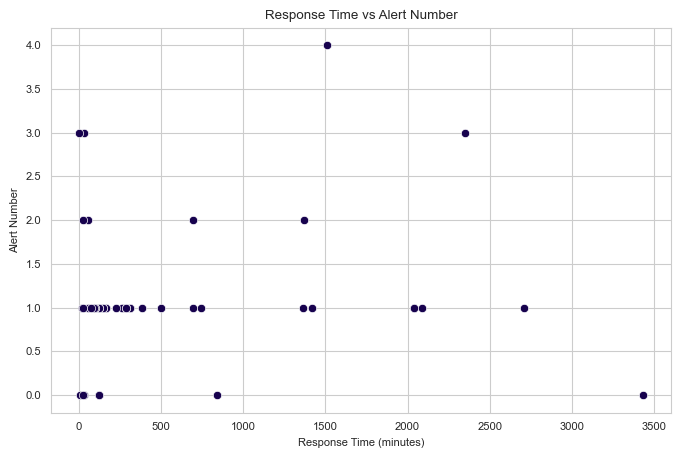

In [381]:
df_responsetime = get_protocols_response_time(df_conversations, 'Sintrom')

plt.rcParams['figure.figsize'] = [6, 4]  

sns.set_style('whitegrid')

plt.figure(figsize=(8, 5))  # You can adjust the figure size as needed
sns.scatterplot(x='timeToConvert', y='alertNumber', data=df_responsetime)

# Adding labels and title for clarity
plt.xlabel('Response Time (minutes)')
plt.ylabel('Alert Number')
plt.title('Response Time vs Alert Number')

plt.show()